# Random events

Looking at Lorenz curves at different scales and offsets for purely random data

Essentially investigating the MAUP...

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
from datetime import datetime
from zoneinfo import ZoneInfo

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from spatial import SpatialUnit, map_to_spatial_unit
from utils import get_force_boundary, get_hex_grid, get_square_grid, lorenz_curve


In [15]:
TZ = ZoneInfo("Europe/London")
FORCE = "West Yorkshire"
# timespan = timedelta(years=3)
timespan = 3  # years
end_date = datetime(2025, 5, 1, tzinfo=TZ)
rng = np.random.default_rng(19937)

N_CRIMES = 80000

start_date = end_date.replace(year=end_date.year - timespan)
boundary = get_force_boundary(FORCE)

# < v1.1 has a bug where samples are not uniform
assert [int(i) for i in gpd.__version__.split(".")] >= [1, 1, 0]
crimes = gpd.GeoDataFrame(
    data={"timestamp": rng.uniform(start_date.timestamp(), end_date.timestamp(), size=N_CRIMES)},
    geometry=boundary.geometry.sample_points(N_CRIMES, rng=rng).explode(ignore_index=True),
)
crimes.timestamp = pd.to_datetime(crimes.timestamp, unit="s")
crimes

,timestamp,geometry
0,2023-07-23 03:58:31.562216520,POINT (388710.885 425129.111)
1,2025-01-17 22:17:42.491240501,POINT (388782.375 425186.681)
2,2023-11-20 06:52:30.328463316,POINT (388792.719 425428.237)
3,2022-11-04 17:47:01.892280817,POINT (388794.584 425020.003)
4,2023-03-23 13:14:47.199398518,POINT (388800.378 425079.356)
...,...,...
79995,2024-09-23 13:31:21.627681017,POINT (452875.363 423060.459)
79996,2023-11-28 08:06:06.305001020,POINT (452901.263 422559.972)
79997,2023-09-17 12:11:29.941725254,POINT (452931.39 422808.765)
79998,2024-01-06 19:55:41.313209057,POINT (452933.025 422512.539)


In [21]:
sgrid = get_square_grid(1000.0, boundary, offset=(0, 0))  # , offset=(0.0, 0.0))
sgrid

,geometry
75,"POLYGON ((388000 424000, 389000 424000, 389000..."
76,"POLYGON ((388000 425000, 389000 425000, 389000..."
125,"POLYGON ((389000 422000, 390000 422000, 390000..."
126,"POLYGON ((389000 423000, 390000 423000, 390000..."
127,"POLYGON ((389000 424000, 390000 424000, 390000..."
...,...
3349,"POLYGON ((451000 422000, 452000 422000, 452000..."
3350,"POLYGON ((451000 423000, 452000 423000, 452000..."
3351,"POLYGON ((451000 424000, 452000 424000, 452000..."
3401,"POLYGON ((452000 422000, 453000 422000, 453000..."


In [41]:
# crimes_by_sq = sgrid.sjoin(crimes, how="right").groupby("index_left").PFA23CD.count().rename("count")
# # restore the crime-free OAs by left joining on the full set
# sgrid = sgrid.join(crimes_by_sq, how="left").fillna(0)
crimes_by_sq, sgrid = map_to_spatial_unit(crimes, boundary, "HEX", resolution=8)

counts = sgrid.join(crimes_by_sq.groupby("spatial_unit").size().rename("count")).fillna(0)
counts.explore(
    "count",
    cmap="Reds",
    tiles="CartoDB positron",
    style_kwds=dict(color="black", weight=0.5, opacity=0.4, fillOpacity=0.7),
)

np.float64(1000000.0)

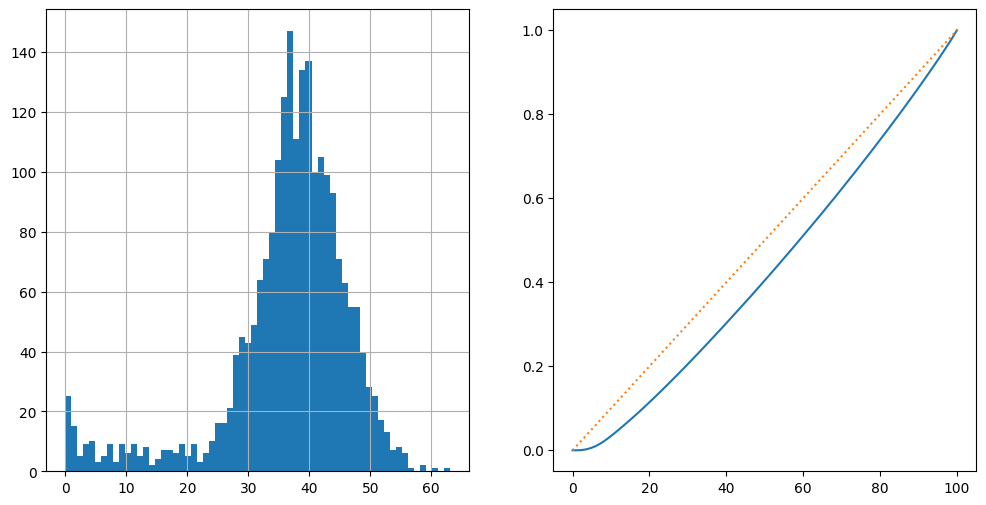

In [8]:
assert sgrid["count"].sum() == N_CRIMES

# sgrid["density"] = sgrid["count"] / sgrid.geometry.area
_, axs = plt.subplots(1, 2, figsize=(12, 6))
sgrid["count"].hist(bins=int(sgrid["count"].max() + 1), ax=axs[0])
lorenz_curve(sgrid["count"], percentiles=True).plot(ax=axs[1])
axs[1].plot([0, 100], [0, 1.0], ls=":")
sgrid.geometry.area.mean()

In [14]:
hgrid = get_hex_grid(7, FORCE)  # , offset=(0, 0)) #, offset=(0.0, 0.0))
# grid

crimes_by_sq = hgrid.sjoin(crimes, how="right").groupby("h3_polyfill").PFA23CD.count().rename("count")
# restore the crime-free OAs by left joining on the full set
hgrid = hgrid.join(crimes_by_sq, how="left").fillna(0)
map = hgrid.explore(
    "count",
    cmap="Reds",
    tiles="CartoDB positron",
    style_kwds=dict(color="black", weight=0.5, opacity=0.4, fillOpacity=0.7),
)
# boundary.explore(m=map)
map

np.float64(4568420.7925940445)

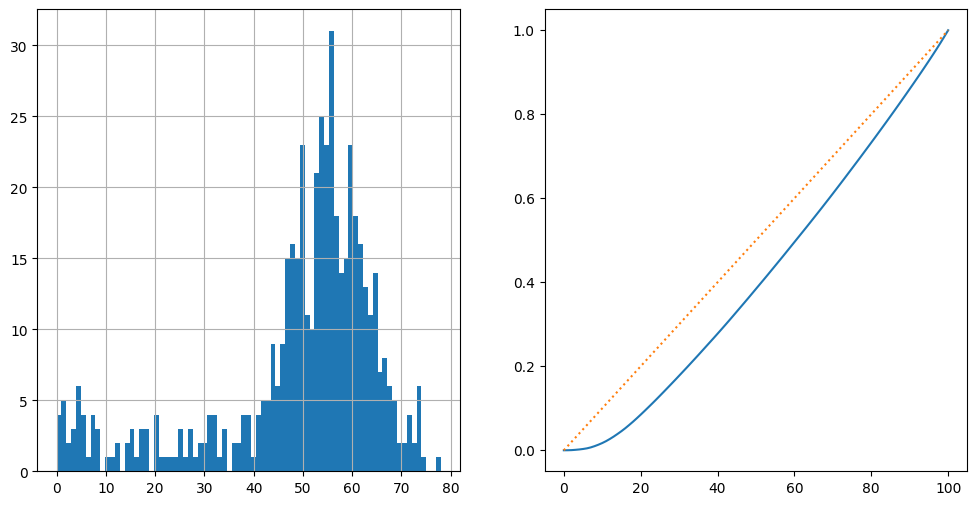

In [15]:
assert hgrid["count"].sum() == N_CRIMES, (hgrid["count"].sum(), N_CRIMES)

hgrid["density"] = hgrid["count"] / hgrid.geometry.area
_, axs = plt.subplots(1, 2, figsize=(12, 6))
hgrid["count"].hist(bins=int(hgrid["count"].max() + 1), ax=axs[0])
lorenz_curve(hgrid["count"], percentiles=True).plot(ax=axs[1])
axs[1].plot([0, 100], [0, 1.0], ls=":")
hgrid.geometry.area.mean()

In [16]:
hgrid

,geometry,PFA23CD,PFA23NM,count,density
h3_polyfill,,,,,
871942119ffffff,"POLYGON ((440183.584 420105.692, 439184.36 419...",E23000010,West Yorkshire,60.0,0.000013
871942036ffffff,"POLYGON ((433463.518 419537.931, 432463.241 41...",E23000010,West Yorkshire,60.0,0.000013
871942531ffffff,"POLYGON ((399969.21 441167.808, 398964.856 440...",E23000010,West Yorkshire,62.0,0.000014
871942ceeffffff,"POLYGON ((420892.87 438836.308, 419891.598 438...",E23000010,West Yorkshire,48.0,0.000011
871942176ffffff,"POLYGON ((449134.908 420862.009, 448137.089 42...",E23000010,West Yorkshire,31.0,0.000007
...,...,...,...,...,...
871942553ffffff,"POLYGON ((404324.491 423194.809, 403319.945 42...",E23000010,West Yorkshire,52.0,0.000011
871942c40ffffff,"POLYGON ((432096.572 439768.711, 431097.058 43...",E23000010,West Yorkshire,51.0,0.000011
871942c6dffffff,"POLYGON ((440290.807 438418.865, 439292.481 43...",E23000010,West Yorkshire,56.0,0.000012
